

# Surface Crack Detection with mobilenet
Concrete surface sample images for Surface Crack Detection


About Dataset
Surface Crack Detection Dataset

## Context

콘크리트 표면의 균열은 토목 구조물에서 주요한 결함입니다. 건물 점검은 건물의 강성과 인장 강도 평가를 위해 이루어집니다. 균열 탐지는 건물 점검에서 중요한 역할을 하는데, 이는 균열을 찾고 건물의 건강 상태를 결정하는 데 도움이 됩니다.

## Content
이 데이터셋에는 균열이 있는/없는 다양한 콘크리트 표면의 이미지들이 포함되어 있습니다. 이미지 데이터는 이미지 분류를 위해 균열이 없는 경우(음성)와 균열이 있는 경우(양성)로 나누어진 별도의 폴더에 담겨 있습니다. 각 클래스는 총 40000개의 이미지 중 20000개의 이미지를 가지며, 각 이미지는 RGB 채널을 가진 227 x 227 픽셀입니다. 이 데이터셋은 Zhang 등이 제안한 방법을 사용하여 458장의 고해상도 이미지(4032x3024 픽셀)로부터 생성되었습니다. 고해상도 이미지는 표면 마감과 조명 상태에서 높은 변동성을 보였습니다. 무작위 회전이나 뒤집기, 기울기 등의 데이터 증강은 적용되지 않았습니다.


* http://210.115.229.18/surface_crack.zip

* https://www.kaggle.com/datasets/arunrk7/surface-crack-detection


In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Dropout, Dense, Conv2D, GlobalAveragePooling2D, MaxPool2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.applications import MobileNet, Xception, ResNet50, InceptionV3

In [2]:
import os

ROOT_DIR = './'

DATA_ROOT_DIR = os.path.join(ROOT_DIR, 'surface_crack')

TRAIN_DATA_ROOT_DIR = os.path.join(DATA_ROOT_DIR, 'train')

TEST_DATA_ROOT_DIR = os.path.join(DATA_ROOT_DIR, 'test')

# ImageDataGenerator 이용하여 데이터 불러옴

In [3]:
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.20)  # 20% 비율로 validation 생성

validation_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.20)

test_datagen = ImageDataGenerator(rescale=1./255 )

# 이미지 shape 설정

In [4]:
IMG_WIDTH = 128
IMG_HEIGHT = 128

# flow_from_directory 설정

In [5]:
train_generator = train_datagen.flow_from_directory(TRAIN_DATA_ROOT_DIR, batch_size=32,
                                                color_mode='rgb', class_mode='sparse',
                                                target_size=(IMG_WIDTH,IMG_HEIGHT),
                                                subset='training')


validation_generator = validation_datagen.flow_from_directory(TRAIN_DATA_ROOT_DIR, batch_size=32,
                                                color_mode='rgb', class_mode='sparse',
                                                target_size=(IMG_WIDTH,IMG_HEIGHT),
                                                subset='validation')


test_generator = test_datagen.flow_from_directory(TEST_DATA_ROOT_DIR, batch_size=32, 
                                              color_mode='rgb', class_mode='sparse',
                                              target_size=(IMG_WIDTH,IMG_HEIGHT))

Found 25600 images belonging to 2 classes.
Found 6400 images belonging to 2 classes.
Found 8000 images belonging to 2 classes.


In [6]:
print(train_generator.class_indices)
print(train_generator.num_classes)

{'Negative': 0, 'Positive': 1}
2


# 32 개의 데이터와 정답 가져와서 출력

In [7]:
data, label = train_generator.next()

print(data.shape, label.shape)
print(label)

(32, 128, 128, 3) (32,)
[0. 1. 0. 0. 0. 1. 0. 0. 1. 1. 1. 0. 1. 1. 0. 1. 1. 1. 0. 1. 1. 0. 0. 0.
 0. 1. 0. 0. 1. 0. 0. 0.]


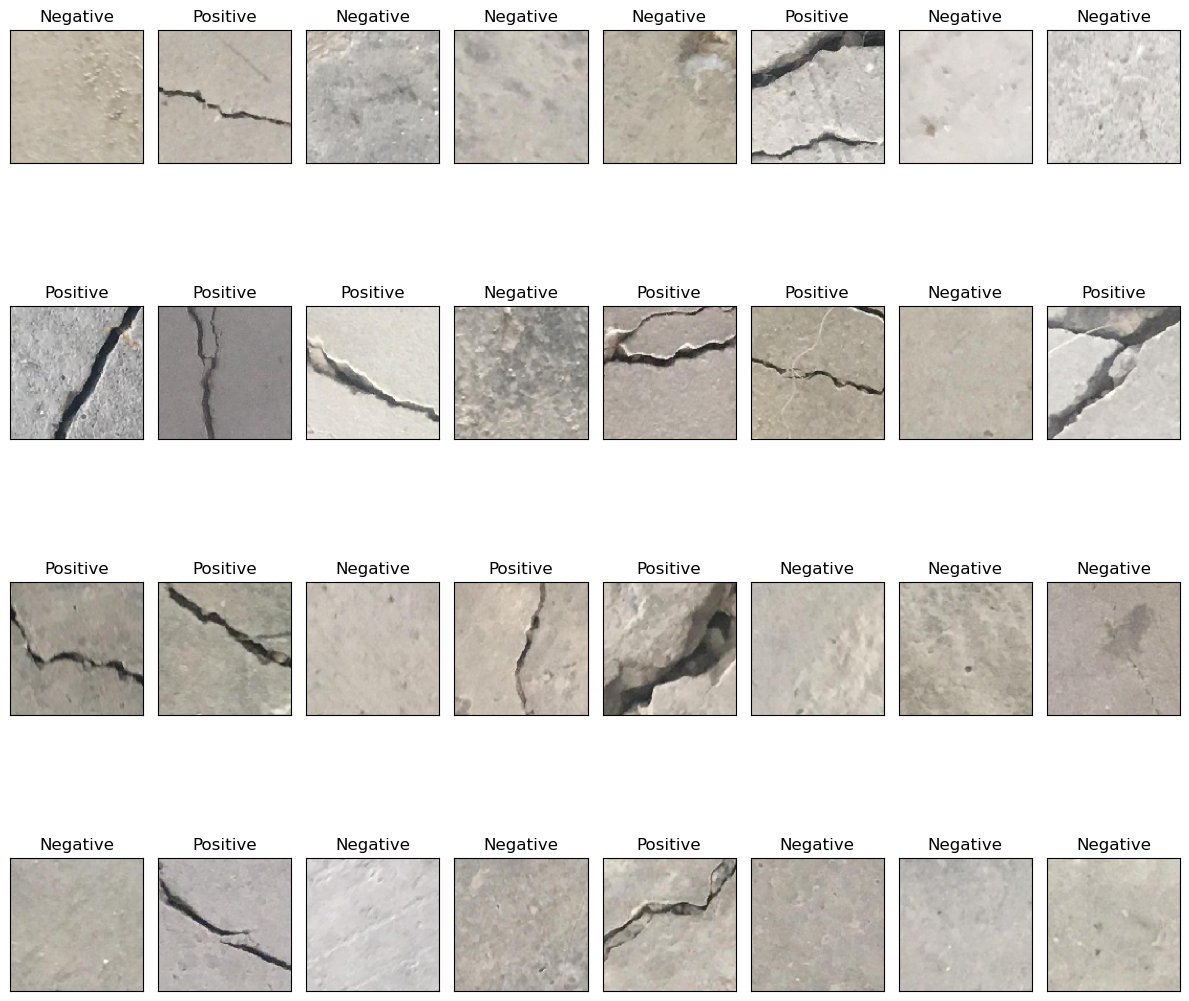

In [8]:
import matplotlib.pyplot as plt

class_dict = { 0:'Negative', 1:'Positive' }

plt.figure(figsize=(12,12))

for i in range(len(label)):

    plt.subplot(4, 8, i+1)
    plt.title(str(class_dict[label[i]]))
    plt.xticks([]);  plt.yticks([])

    plt.imshow(data[i])

plt.tight_layout()
plt.show()

# CNN model 정의 및 모델 구축

In [10]:
from keras.applications import MobileNet
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(IMG_WIDTH,IMG_HEIGHT,3))
class_nums = train_generator.num_classes 

model = Sequential()

model.add(base_model)

model.add(Flatten())

model.add(Dense(32, activation='relu'))
model.add(Dropout(0.25))                  
model.add(Dense(class_nums, activation='softmax'))


model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_128 (Functi  (None, 4, 4, 1024)        3228864   
 onal)                                                           
                                                                 
 flatten_1 (Flatten)         (None, 16384)             0         
                                                                 
 dense_1 (Dense)             (None, 32)                524320    
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 2)                 66        
                                                                 
Total params: 3753250 (14.32 MB)
Trainable params: 3731362 (14.23 MB)
Non-trainable params: 21888 (85.50 KB)
___________

In [11]:
model.compile(loss='sparse_categorical_crossentropy', 
            optimizer=tf.keras.optimizers.Adam(1e-4), metrics=['acc'])

In [12]:
from tensorflow.keras.callbacks import EarlyStopping
from datetime import datetime

earlystopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1)


start_time = datetime.now()

hist = model.fit(train_generator, epochs=3, validation_data=validation_generator, 
                 callbacks=[earlystopping])

end_time = datetime.now()

print('Elapsed Time => ', end_time-start_time)

Epoch 1/3
800/800 [==============================] - 320s 395ms/step - loss: 0.0340 - acc: 0.9896 - val_loss: 0.0031 - val_acc: 0.9987
Epoch 2/3
800/800 [==============================] - 321s 401ms/step - loss: 0.0098 - acc: 0.9970 - val_loss: 0.0032 - val_acc: 0.9989
Epoch 3/3
800/800 [==============================] - 317s 396ms/step - loss: 0.0053 - acc: 0.9982 - val_loss: 0.0082 - val_acc: 0.9981
Elapsed Time =>  0:15:57.173609


In [ ]:
import matplotlib.pyplot as plt

plt.plot(hist.history['acc'], label='train')
plt.plot(hist.history['val_acc'], label='validation')
plt.title('Accuracy Trend')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(loc='best')
plt.grid()
plt.show()

In [ ]:
plt.plot(hist.history['loss'], label='train')
plt.plot(hist.history['val_loss'], label='validation')
plt.title('Loss Trend')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='best')
plt.grid()
plt.show()

In [ ]:
model.evaluate(test_generator)